<a href="https://colab.research.google.com/github/h-neal/Matt-Macarty-Algorithmic-Trading-Youtube-Series/blob/main/1_How_to_Create_%26_Test_Trading_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Developing "Momentum" Trading Strategy**

- Many different takes on this strategy
- Sometimes referred to as trend following
- Whatever you do and call it, you first need to research potential trading signals

In [70]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import pandas as pd

## **1. Download data:**

- Many services for this, some paid some free
- Yahoo Finance API
- Typically trading "systems" involve a number of securtities
- For this demonstration, we are just looking at GLD -> the gold ETF

In [71]:
gld = yf.download('GLD')
day = np.arange(1, len(gld)+ 1 )
gld['day'] = day
gld.drop(columns=['Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

[*********************100%***********************]  1 of 1 completed


Price,day,Open,High,Low,Close
Ticker,,GLD,GLD,GLD,GLD
Date,,,,,
2004-11-18,1,44.430000,44.490002,44.070000,44.380001
2004-11-19,2,44.490002,44.919998,44.470001,44.779999
2004-11-22,3,44.750000,44.970001,44.740002,44.950001
2004-11-23,4,44.880001,44.919998,44.720001,44.750000
2004-11-24,5,44.930000,45.049999,44.790001,45.049999


In [72]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5150 entries, 2004-11-18 to 2025-05-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (day, )       5150 non-null   int64  
 1   (Open, GLD)   5150 non-null   float64
 2   (High, GLD)   5150 non-null   float64
 3   (Low, GLD)    5150 non-null   float64
 4   (Close, GLD)  5150 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 241.4 KB


## **2. Add data/transfrom data**

- calculate signal based on some price or statistical action
- we are going to try a moving average crossover to generate signals
- for this strategy, we will always be "in" a trade, either long or short
- we are modelling, this means real life validation should be expected

**Add moving averages to the data frame**

In [73]:
gld_copy = gld.copy()  # Create a copy with only 'Close'
gld_copy['9-day'] = gld_copy['Close'].rolling(9).mean().shift()
gld_copy['21-day'] = gld_copy['Close'].rolling(21).mean().shift()
display(gld_copy[22:26])

Price,day,Open,High,Low,Close,9-day,21-day
Ticker,,GLD,GLD,GLD,GLD,,
Date,,,,,,,
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571


**Add "signal" action**

In [74]:
gld_copy['signal'] = np.where(gld_copy['9-day'] > gld_copy['21-day'], 1, 0)
gld_copy['signal'] = np.where(gld_copy['9-day'] < gld_copy['21-day'], -1, gld_copy['signal'])
gld_copy.dropna(inplace=True)
gld_copy.head()

Price,day,Open,High,Low,Close,9-day,21-day,signal
Ticker,,GLD,GLD,GLD,GLD,,,
Date,,,,,,,,
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286,-1
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381,-1
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714,-1
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428,-1
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571,-1


**Calculate Instantaneous returns/system retruns**

In [76]:
gld_copy_2 = gld_copy.copy()
gld_copy_2['return'] = np.log(gld_copy_2['Close']).diff()
gld_copy_2['system_return'] = gld_copy_2['signal'] * gld_copy_2['return']
gld_copy_2['entry'] = gld_copy_2.signal.diff()
gld_copy_2.head()

Price,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Ticker,,GLD,GLD,GLD,GLD,,,,,,
Date,,,,,,,,,,,
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286,-1,NaN,NaN,NaN
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381,-1,-0.002710,0.002710,0.0
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714,-1,-0.004533,0.004533,0.0
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428,-1,0.005663,-0.005663,0.0
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571,-1,0.004732,-0.004732,0.0


In [78]:
gld_copy['return'] = np.log(gld_copy['Close']).diff()
gld_copy['system_return'] = gld_copy['signal'] * gld_copy['return']
gld_copy['entry'] = gld_copy.signal.diff()
gld_copy.head()

Price,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Ticker,,GLD,GLD,GLD,GLD,,,,,,
Date,,,,,,,,,,,
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286,-1,NaN,NaN,NaN
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381,-1,-0.002710,0.002710,0.0
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714,-1,-0.004533,0.004533,0.0
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428,-1,0.005663,-0.005663,0.0
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571,-1,0.004732,-0.004732,0.0


**Plot trades on time series**

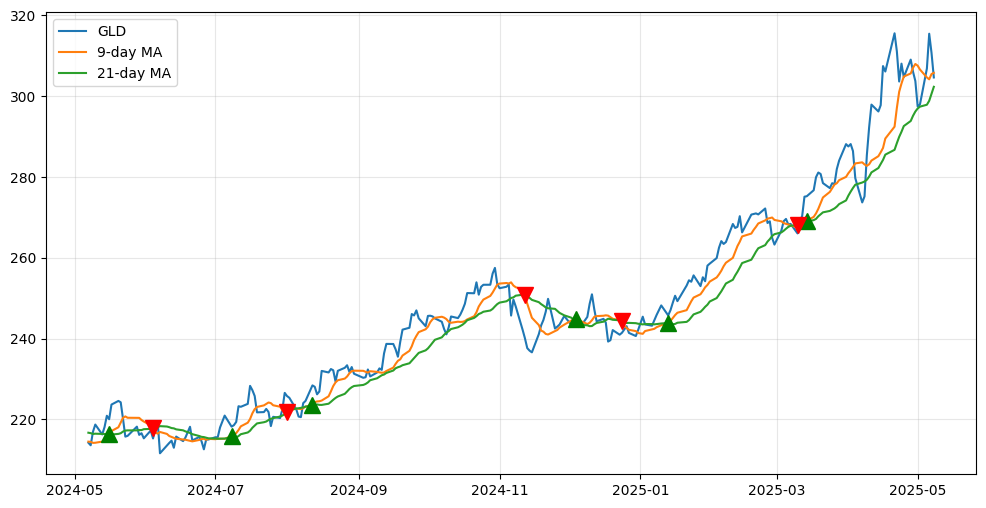

In [79]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.grid(True, alpha = .3)
plt.plot(gld_copy.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld_copy.iloc[-252:]['9-day'], label = '9-day MA')
plt.plot(gld_copy.iloc[-252:]['21-day'], label = '21-day MA')
plt.plot(gld_copy[-252:].loc[gld_copy.entry == 2].index, gld_copy[-252:]['9-day'][gld_copy.entry ==2], '^',
          color = 'g', markersize = 12)
plt.plot(gld_copy[-252:].loc[gld_copy.entry == -2].index, gld_copy[-252:]['21-day'][gld_copy.entry ==-2], 'v',
          color = 'r', markersize = 12)
plt.legend(loc=2);

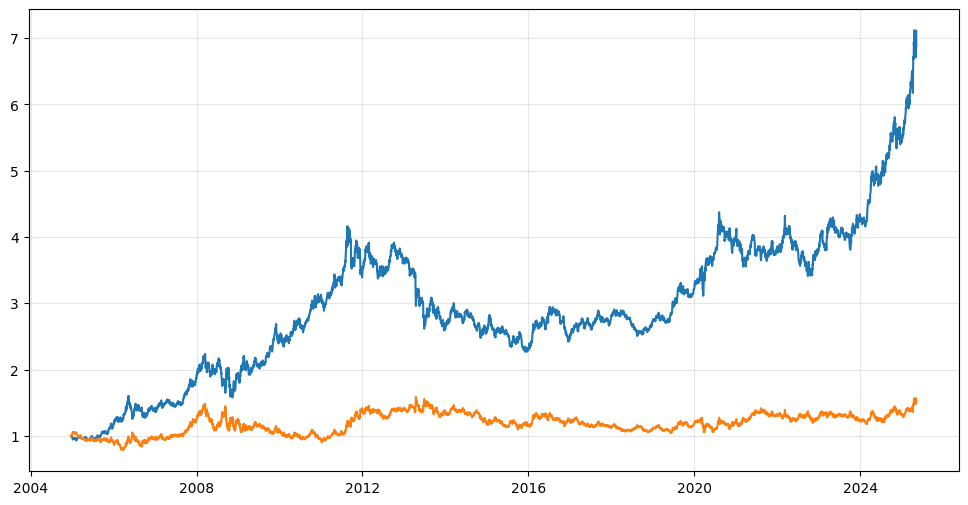

In [81]:
plt.plot(np.exp(gld_copy_2['return']).cumprod(), label = 'Buy/Hold') # Blue Line
plt.plot(np.exp(gld_copy_2['system_return']).cumprod(), label = 'System') # Orange Line
plt.grid(True, alpha=.3)

In [84]:
np.exp(gld_copy_2['return']).cumprod()[-1] -1

<ipython-input-84-8f1600036076>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld_copy_2['return']).cumprod()[-1] -1


np.float64(5.870771151287518)

In [85]:
np.exp(gld_copy_2['system_return']).cumprod()[-1] -1

<ipython-input-85-836b233f1fcb>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld_copy_2['system_return']).cumprod()[-1] -1


np.float64(0.512570805721732)